In [20]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
%run Accuracy_Module.py
%run DataLoading.py
%run load_and_organize_dataset.py

In [22]:
train_loader, val_loader, test_loader = load_dataset(32)

['44', '61', '9', '63', '7', '43', '14', '32', '25', '46', '74', '90', '94', '68', '57', '33', '37', '88', '16', '77', '17', '66', '23', '36', '11', '2', '45', '20', '12', '13', '22', '19', '30', '26', '38', '18', '58', '79', '6', '71', '54', '52', '27', '60', '56', '48', '64', '1', '29', '83', '4', '84', '5', '81', '55', '50', '78', '49', '35', '75', '80', '65', '70', '41', '51', '47', '10', '82', '28', '40', '91', '62', '67', '39', '76', '53', '8', '24', '59', '87', '95', '72', '73', '15', '85', '89', '31', '86', '92', '34', '93', '3', '69', '42', '21']
['44', '61', '9', '63', '7', '43', '14', '32', '25', '46', '74', '90', '94', '68', '57', '33', '37', '88', '16', '77', '17', '66', '23', '36', '11', '2', '45', '20', '12', '13', '22', '19', '30', '26', '38', '18', '58', '79', '6', '71', '54', '52', '27', '60', '56', '48', '64', '1', '29', '83', '4', '84', '5', '81', '55', '50', '78', '49', '35', '75', '80', '65', '70', '41', '51', '47', '10', '82', '28', '40', '91', '62', '67', '39', 

In [29]:
class conv_net(nn.Module):
    def __init__(self):
        super(conv_net, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 12, 5) 
        self.pool1 = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(12, 48, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(48, 96, 5)
        self.fc1 = nn.Linear(3456, 3456)
        self.fc2 = nn.Linear(3456, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 1)
    def forward(self, x):
        x = x.cuda()
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x.squeeze(1)
        
        return x

In [23]:
vgg16 = models.vgg16()
vgg16 = nn.Sequential(vgg16.features, vgg16.avgpool)

pre_trained = torch.load("vgg_face_dag.pth")
new = list(pre_trained.items())
vgg16_state = vgg16.state_dict()
count = 0
for key, value in vgg16_state.items():
    layer_name, weights = new[count]      
    vgg16_state[key] = weights
    count += 1

vgg16.load_state_dict(vgg16_state)

In [24]:
vgg16.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [25]:
def train_net(net, batch_size=32, learning_rate=1e-4, num_epochs=10):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    from torch.autograd import Variable
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    #train_loader, val_loader, test_loader = get_data_loader(range(1,101) ,batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be 
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            
            outputs = net(inputs.cuda())        

            loss = criterion(outputs.cuda(), labels.float().cuda())
            loss.backward()
            optimizer.step()
            if(n%50==0):
                 print(n)

            total_epoch += len(labels)
            n+=1
            
        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(net, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            
        print("Epoch: {}, Training Loss: {:.3f}, Training R^2: {:.3f}, Validation R^2: {:.3f}".format(epoch+1, losses[-1],train_acc[-1],val_acc[-1]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name("vgg", batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training R^2: {}".format(train_acc[-1]))
    print("Final Validation R^2: {}".format(val_acc[-1]))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [26]:
class VGG_classifier(nn.Module):
    def __init__(self, num_classes):
        super(VGG_classifier, self).__init__()
        self.name = "vgg_class"
        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.cuda()
        x = vgg16(torch.autograd.Variable(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)        
        x = self.softmax(x)

        ranges = torch.tensor(np.arange(1,96)).float()
        ranges = torch.tensor(np.tile(ranges,(x.shape[0],1)), requires_grad=True).cuda()
        
        ranges = torch.autograd.Variable(ranges, requires_grad=True)
        x = x * ranges
        
        x = x.sum(dim=1)

        return x

In [27]:
vgg_class = VGG_classifier(95)
vgg_class.cuda()

VGG_classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=95, bias=True)
  (softmax): Softmax()
)

In [ ]:
train_net(vgg_class, batch_size=32, learning_rate=1e-5, num_epochs=10)

0
50
100
150
200
250
300


In [20]:
testing = VGG_classifier(116)
testing.load_state_dict(torch.load(get_model_name("vgg", 32, 1e-4, 2)))
testing.cuda()

VGG_classifier(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=116, bias=True)
  (softmax): Softmax()
)

In [24]:
train_net(testing, batch_size=32, learning_rate=1e-5, num_epochs=5)

0
50
100
150
200
250
300
350
400
450
500
Epoch: 1, Training Loss: 1.205, Training R^2: 0.919, Validation R^2: 0.864
550
600
650
700
750
800
850
900
950
1000
1050
Epoch: 2, Training Loss: 0.930, Training R^2: 0.925, Validation R^2: 0.865
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
Epoch: 3, Training Loss: 1.332, Training R^2: 0.931, Validation R^2: 0.865
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
Epoch: 4, Training Loss: 0.888, Training R^2: 0.936, Validation R^2: 0.864
2150
2200


KeyboardInterrupt: 

In [25]:
get_accuracy(testing, test_loader)

tensor(0.8390)

+/- 5 years accuracy: 60.70%
+/- 10 years accuracy: 88.75%


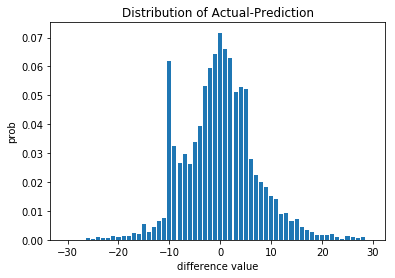

In [26]:
get_off_accuracy(testing, test_loader)

+/- 5 years accuracy: 57.43%
+/- 10 years accuracy: 88.47%


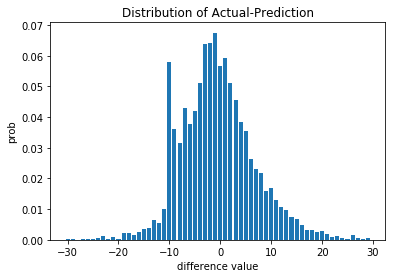

In [22]:
get_off_accuracy(testing, val_loader)

+/- 5 years accuracy: 64.21%
+/- 10 years accuracy: 93.26%


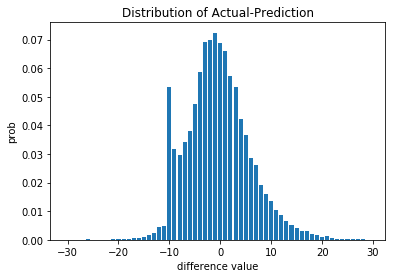

In [23]:
get_off_accuracy(testing, train_loader)

In [ ]:
k = 0
for image, label in test_loader:
    img = image[0]
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    k += 1
    print(label[0], testing(img))
    if k > 10:
        break